In [258]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import matplotlib.path as mpath
import pandasql as sql
from matplotlib.collections import LineCollection
from math import sin, cos, atan2, sqrt, degrees, radians, pi
from geopy.distance import great_circle as distance
from geopy.point import Point
from haversine import haversine,Unit

In [259]:
filepath = r"C:\Users\NImi Jithin\Desktop\Studies\sem-3\research track\SegmentTable.csv"
df = pd.read_csv(filepath)

#df = df.iloc[3300:,]
#df = df.iloc[:500]
filepath = r"C:\Users\NImi Jithin\Desktop\Studies\sem-3\research track\Measurements\m90.csv"
measuresdf = pd.read_csv(filepath)
measuresdf =  measuresdf.iloc[2000:,]

In [260]:
#q1 = """SELECT * FROM df WHERE Start_Longitude > 10.34  AND Start_Latitude <51.84 """
#df = sql.sqldf(q1, locals())

In [261]:
len(df)

8862

In [262]:
strtlon, strtlat = df.Start_Longitude.values, df.Start_Latitude.values
endlon, endlat = df.End_Longitude.values, df.End_Latitude.values

In [263]:
pts = np.c_[strtlon, strtlat,endlon, endlat].reshape(len(strtlon), 2, 2)
xtrapts = pts[:len(pts)-0]
#xtrapts = pts[5000:5540,:]

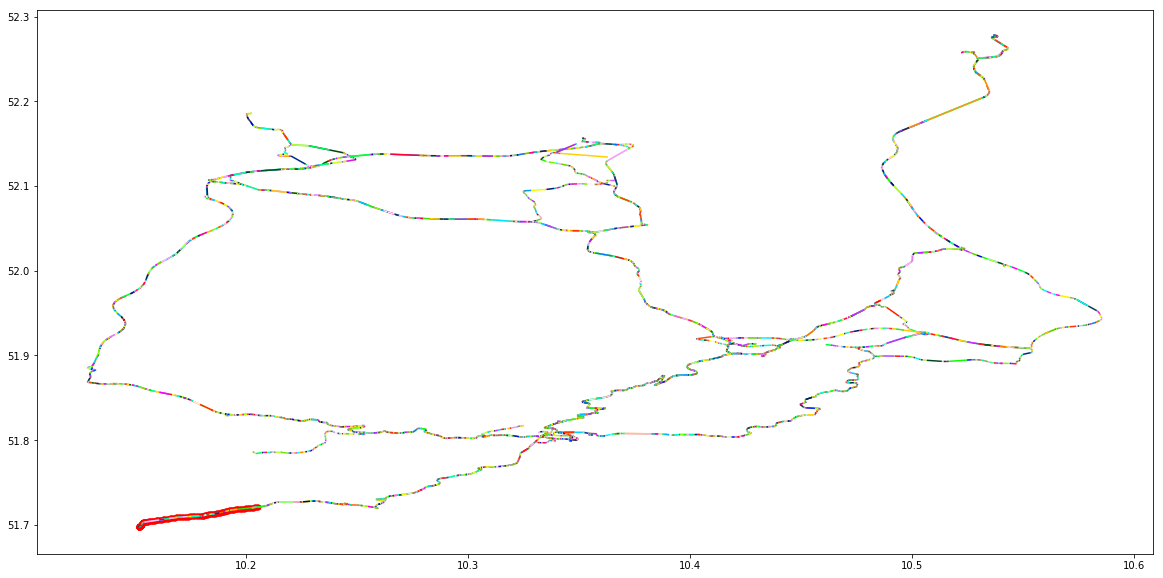

In [264]:
#segments = np.hstack([xtrapts[:-1], xtrapts[1:]])
#plot segments-------------------------------------------------------------


fig, ax = plt.subplots()
#ax.set_xlim([10.30, 10.45])
plt.rcParams["figure.figsize"] = (20,10)
coll = LineCollection(xtrapts, cmap=plt.cm.gist_ncar)
coll.set_array(np.random.random(xtrapts.shape[0]))

ax.add_collection(coll)
ax.autoscale_view()

#plot measurements ---------------------------------------------------------
xMeasurement, yMeasurement =  measuresdf.long.values, measuresdf.lat.values
ax.scatter(xMeasurement,yMeasurement,s=20, color='r')


In [265]:
def midpoint(a, b):
    a_lat, a_lon = radians(a.latitude), radians(a.longitude)
    b_lat, b_lon = radians(b.latitude), radians(b.longitude)
    delta_lon = b_lon - a_lon
    B_x = cos(b_lat) * cos(delta_lon)
    B_y = cos(b_lat) * sin(delta_lon)
    mid_lat = atan2(
        sin(a_lat) + sin(b_lat),
        sqrt(((cos(a_lat) + B_x)**2 + B_y**2))
    )
    mid_lon = a_lon + atan2(B_y, cos(a_lat) + B_x)
    # Normalise
    mid_lon = (mid_lon + 3*pi) % (2*pi) - pi
    return (degrees(mid_lat), degrees(mid_lon))


In [266]:
df.head()

,Segment_ID,Start_Longitude,Start_Latitude,End_Longitude,End_Latitude
0,1,10.128375,51.868551,10.128433,51.868380
1,2,10.128384,51.868665,10.128375,51.868551
2,3,10.128433,51.868380,10.128498,51.868291
3,4,10.128443,51.885236,10.128478,51.884912
4,5,10.128471,51.885496,10.128443,51.885236


In [267]:
df['Segment_Length'] = ''

In [268]:
#Calculate Segment Midpoints

for indexSeg, rowSeg in df.iterrows():
    a = Point(rowSeg['Start_Latitude'], longitude=rowSeg['Start_Longitude'])
    b = Point(rowSeg['End_Latitude'], longitude=rowSeg['End_Longitude'])
    x = midpoint(a,b)
    df.loc[indexSeg,'Mid_Latitude'] = x[0]
    df.loc[indexSeg,'Mid_Longitude'] = x[1]
    df.loc[indexSeg,'Segment_Length'] = distance(a,b)

In [269]:
df.tail()

,Segment_ID,Start_Longitude,Start_Latitude,End_Longitude,End_Latitude,Segment_Length,Mid_Latitude,Mid_Longitude
8857,8858,10.584996,51.941835,10.584822,51.941509,0.038161417229619354 km,51.941672,10.584909
8858,8859,10.585191,51.944880,10.585351,51.943976,0.10111684361280522 km,51.944428,10.585271
8859,8860,10.585287,51.942643,10.584996,51.941835,0.09203328034637398 km,51.942239,10.585141
8860,8861,10.585351,51.943976,10.585375,51.943297,0.07551938165295362 km,51.943637,10.585363
8861,8862,10.585375,51.943297,10.585287,51.942643,0.07297132441210273 km,51.942970,10.585331


In [270]:
measuresdf['PredictedSeg'] = ''

In [271]:
measuresdf.head()

,time,lat,long,dir,velocity,T_outside,brightnessFW,brightnessIR,PredictedSeg
2000,"Wednesday, February 13, 2019 16:11:19:47852807",51.721000,10.205450,242.0,76.362938,6.5,3696.311727,6800.000000,
2001,"Wednesday, February 13, 2019 16:11:19:97853540",51.721000,10.205450,242.0,77.162928,6.5,3696.288333,7200.000000,
2002,"Wednesday, February 13, 2019 16:11:20:47853271",51.720920,10.205185,242.0,77.448399,6.5,3598.433090,6800.000000,
2003,"Wednesday, February 13, 2019 16:11:20:97852978",51.720920,10.205185,242.0,77.414498,6.5,3459.674518,6400.000000,
2004,"Wednesday, February 13, 2019 16:11:21:47852709",51.720828,10.204914,241.8,75.505998,6.5,3479.298767,6807.791478,


In [275]:
for indexMess, rowMess in measuresdf.iterrows():
    messDistMap = dict()
    b = [rowMess['lat'],rowMess['long']]
    for indexSeg, rowSeg in df.iterrows():
        a  = [rowSeg['Mid_Latitude'],rowSeg['Mid_Longitude']]
        dist = distance(a,b) #------- TODO : need to normalise the distance 
        messDistMap.update({rowSeg['Segment_ID']:dist})
    #print(messDistMap)    
    if bool(messDistMap):
        measuresdf.loc[indexMess,'PredictedSeg'] = min(messDistMap, key=messDistMap.get) 
    


In [277]:
measuresdf

,time,lat,long,dir,velocity,T_outside,brightnessFW,brightnessIR,PredictedSeg
2000,"Wednesday, February 13, 2019 16:11:19:47852807",51.721000,10.205450,242.0,76.362938,6.500000,3696.311727,6800.000000,783
2001,"Wednesday, February 13, 2019 16:11:19:97853540",51.721000,10.205450,242.0,77.162928,6.500000,3696.288333,7200.000000,783
2002,"Wednesday, February 13, 2019 16:11:20:47853271",51.720920,10.205185,242.0,77.448399,6.500000,3598.433090,6800.000000,783
2003,"Wednesday, February 13, 2019 16:11:20:97852978",51.720920,10.205185,242.0,77.414498,6.500000,3459.674518,6400.000000,783
2004,"Wednesday, February 13, 2019 16:11:21:47852709",51.720828,10.204914,241.8,75.505998,6.500000,3479.298767,6807.791478,783
2005,"Wednesday, February 13, 2019 16:11:21:97852441",51.720828,10.204914,241.8,73.352630,6.500000,3398.104113,7008.532256,783
2006,"Wednesday, February 13, 2019 16:11:22:47853173",51.720741,10.204648,241.3,72.652698,6.500000,3249.887607,6800.000000,796
2007,"Wednesday, February 13, 2019 16:11:22:97852905",51.720741,10.204648,241.3,72.810857,6.500000,3108.868849,6400.000000,796
2008,"Wednesday, February 13, 2019 16:11:23:47853637",51.720657,10.204392,241.4,73.080000,6.500000,3077.246915,6800.000000,796
2009,"Wednesday, February 13, 2019 16:11:23:97853369",51.720657,10.204392,241.4,73.295187,6.500000,3037.520268,6400.000000,796


In [230]:
q1 = """SELECT distinct(PredictedSeg) FROM measuresdf order by PredictedSeg """
test = sql.sqldf(q1, locals())
test

,PredictedSeg
0,238
1,241
2,243
3,248
4,251
5,252
6,254
7,258
8,260
9,262


In [232]:
df = df[df['Segment_ID'].isin(test['PredictedSeg'])]
#df = df[df['Segment_ID'] == 1]


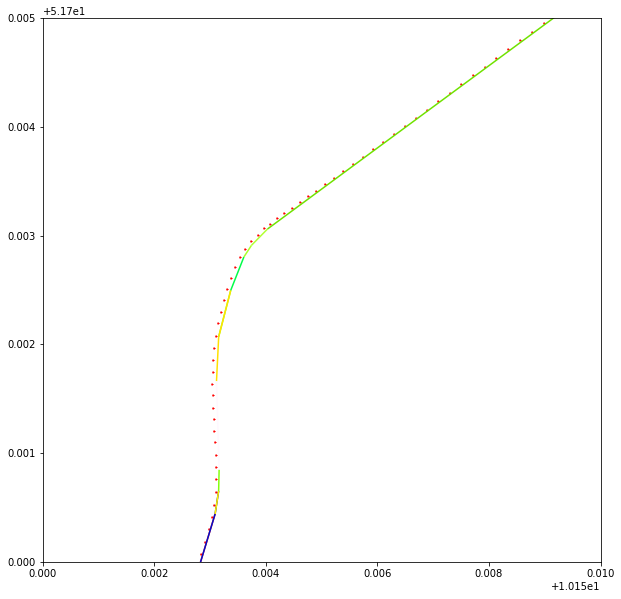

In [242]:
strtlon, strtlat = df.Start_Longitude.values, df.Start_Latitude.values
endlon, endlat = df.End_Longitude.values, df.End_Latitude.values



pts = np.c_[strtlon, strtlat,endlon, endlat].reshape(len(strtlon), 2, 2)
xtrapts = pts[:len(pts)-0]
#xtrapts = pts[5000:5540,:]



#segments = np.hstack([xtrapts[:-1], xtrapts[1:]])
#plot segments-------------------------------------------------------------
fig, ax = plt.subplots()
ax.set_xlim([10.15, 10.16])
ax.set_ylim([51.700, 51.705])
plt.rcParams["figure.figsize"] = (10,10)
coll = LineCollection(xtrapts, cmap=plt.cm.gist_ncar)
coll.set_array(np.random.random(xtrapts.shape[0]))

ax.add_collection(coll)
ax.autoscale_view()

#plot measurements ---------------------------------------------------------
xMeasurement, yMeasurement =  measuresdf.long.values, measuresdf.lat.values
ax.scatter(xMeasurement,yMeasurement,s=1, marker=">",color='r')
